Author: Cezary Januszek

*Created on Saturday, November 15th 2023*
# Flight delays prediction

#### Research question: *What is the influence of the different airlines/airports on the flight delays?*

The goal of this challenge is to investigate US flight delays and cancellations data from 2015.

First some exploratory data analysis is done to try to find some insights from general statistics about the airlines, airports and average flight delays. Second, using this same data the goal consists in creating a flight delay prediction model by implementing a:
1) baseline model
2) complex model (Neural Network or other Deep Learning method)

The second model should have better performance than the baseline due to its increased complexity, which will make it also more difficult to explain its predictions.Therefore, an interpretability framework will be added to the second model to allow explicability of the created predictions.

# IV. Complex prediction model

In [ ]:
# Imports
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.core.pylabtools import figsize
figsize(10, 8)

from helper_functions import *

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics.functional import multiclass_confusion_matrix, multiclass_accuracy, multiclass_precision, multiclass_recall, multiclass_auprc, multiclass_f1_score

#import torch_explain as te
#from torch_explain.logic.nn import entropy

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [ ]:
# load the data
data = pd.read_pickle('drive/MyDrive/FlightDelayPrediction/flights_data.pkl')

### Last pre-processing step for Neural Network

In [ ]:

# cyclical encoding of time and date
data = cyclical_encode(data, 'DAY_OF_WEEK', 7)
data = cyclical_encode(data, 'DEPARTURE_DAY', 31)
data = cyclical_encode(data, 'DEPARTURE_MONTH', 12)
data = cyclical_encode(data, 'ARRIVAL_DAY', 31)
data = cyclical_encode(data, 'ARRIVAL_MONTH', 12)

data = cyclical_encode(data, 'SCHEDULED_DEPARTURE_HOUR', 24)
data = cyclical_encode(data, 'SCHEDULED_DEPARTURE_MIN', 60)
data = cyclical_encode(data, 'SCHEDULED_ARRIVAL_HOUR', 24)
data = cyclical_encode(data, 'SCHEDULED_ARRIVAL_MIN', 60)

data = data.drop(['DAY_OF_WEEK', 'DEPARTURE_DAY', 'DEPARTURE_MONTH', 'ARRIVAL_DAY', 'ARRIVAL_MONTH',
                             'SCHEDULED_DEPARTURE_HOUR', 'SCHEDULED_DEPARTURE_MIN', 'SCHEDULED_ARRIVAL_HOUR', 'SCHEDULED_ARRIVAL_MIN'], axis=1)


## Multi-layer Perceptron for multi-class classification

In [ ]:
#-----------------------------
# Multi-layer Perceptron model
#------------------------------

# Define the Attention Layer
class AttentionLayer(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(AttentionLayer, self).__init__()
        self.W_q = nn.Linear(input_size, hidden_size)
        self.W_k = nn.Linear(input_size, hidden_size)
        self.W_v = nn.Linear(input_size, hidden_size)
        self.W_out = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        x = x.unsqueeze(1)

        query = self.W_q(x)
        key = self.W_k(x)
        value = self.W_v(x)

        # Compute attention weights
        attention_weights = torch.softmax(torch.matmul(query, key.transpose(1,2)), dim=-1)
        # Apply attention weights to values
        attention_values = torch.matmul(attention_weights, value)
        # Combine attended values using a linear layer
        attention_output = self.W_out(attention_values.squeeze(1))

        return attention_output, attention_weights


class MLP(nn.Module):

    def __init__(self, input_size, layer1_size, layer2_size, layer3_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, layer1_size),
            nn.PReLU(),
            nn.Linear(layer1_size, layer2_size),
            nn.PReLU(),
            nn.Linear(layer2_size, layer3_size),
            nn.PReLU(),
            nn.Linear(layer3_size, output_size)
        )
        self.model.to(device)

    def forward(self, x):
        fwd_output = self.model(x)
        return fwd_output


class AttentionMLP(nn.Module):

    def __init__(self, input_size, layer1_size, layer2_size, layer3_size, attention_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, layer1_size),
            nn.PReLU(),
            nn.Linear(layer1_size, layer2_size),
            nn.PReLU(),
            nn.Linear(layer2_size, layer3_size),
            nn.PReLU(),
            AttentionLayer(layer3_size, attention_size)
        )
        self.output_layer = nn.Linear(attention_size, output_size)

        self.layers.to(device)
        self.output_layer.to(device)

    def forward(self, x):
        x, attention_weights = self.layers(x)
        x = torch.relu(x)
        fwd_output = self.output_layer(x)

        return fwd_output, attention_weights

#------------------------------------
# Train and validation loop functions
#------------------------------------

def train_loop(model, train_loader, optim, criterion):
  '''
  Training loop function
  '''
  # Mini-batch loop
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the gradients for each new mini-batch loop
    optim.zero_grad()
    # Forward pass
    outputs, attention_weights = model(inputs)
    # Compute the loss
    loss = criterion(outputs, labels)
    # Backward pass and optimization
    loss.backward()
    optim.step()

  return loss.item(), attention_weights


def test_loop(model, test_loader, loss):
  '''
  Validation loop function
  '''
  # No grad computation is needed
  with torch.no_grad():

    for inputs_test, labels_test in test_loader:
      inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
      # Forward pass
      outputs_test, attention_weights = model(inputs_test)
      # Compute the loss
      loss_test = loss(outputs_test, labels_test)

  return loss_test.item(), attention_weights

## Without DEPARTURE_DELAY feature

In [ ]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop(['DEPARTURE_DELAY', 'ARRIVAL_DELAY'], axis=1))
Y = data['ARRIVAL_DELAY']

In [ ]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
print(Counter(Y_train))

# SMOTE over-sampling
#oversample = SMOTE(sampling_strategy={2: 100000, 3:20000})
#X_train, Y_train = oversample.fit_resample(X_train, Y_train)
# random under-sampling
undersample = RandomUnderSampler(sampling_strategy={0: 500000})
X_train, Y_train = undersample.fit_resample(X_train, Y_train)

# Standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Training data to tensors
X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
Y_train = torch.as_tensor(np.array(Y_train), device=device)
X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.as_tensor(np.array(Y_test), device=device)

Train samples:  976964
Test samples:  418700
Counter({0: 788206, 1: 128950, 2: 50797, 3: 9011})


In [ ]:
# Instantiate the model
mlp_model = MLP(X.shape[1], 100, 100, 100, 4)
# Loss function
loss_criterion = nn.CrossEntropyLoss()
# Adam optimizer
# learning rates tested [1-e3, 1e-4, 1e-5]
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-4)

# Define number of epochs and mini-batch size
num_epochs = 30
# batch sizes tested [500, 1000, 2000]
batch_size = 10000

# DataLoader for creating training and validation batches
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#----------
# Training
#----------

train_loss_array = []
test_loss_array = []

# Epoch loop
for e in range(num_epochs):
  # Training step
  train_loss = train_loop(mlp_model, train_loader, optimizer, loss_criterion, train_loss_array)

  print(f'Epoch [{e+1}/{num_epochs}], Loss: {train_loss:.4f}')


Epoch [1/30], Loss: 0.8046
Epoch [2/30], Loss: 0.7353
Epoch [3/30], Loss: 0.7198
Epoch [4/30], Loss: 0.7114
Epoch [5/30], Loss: 0.7619
Epoch [6/30], Loss: 0.6843
Epoch [7/30], Loss: 0.7136
Epoch [8/30], Loss: 0.7313
Epoch [9/30], Loss: 0.6919
Epoch [10/30], Loss: 0.7107
Epoch [11/30], Loss: 0.7084
Epoch [12/30], Loss: 0.7191
Epoch [13/30], Loss: 0.7179
Epoch [14/30], Loss: 0.7099
Epoch [15/30], Loss: 0.7517
Epoch [16/30], Loss: 0.7231
Epoch [17/30], Loss: 0.7202
Epoch [18/30], Loss: 0.7503
Epoch [19/30], Loss: 0.7217
Epoch [20/30], Loss: 0.6848
Epoch [21/30], Loss: 0.6985
Epoch [22/30], Loss: 0.7089
Epoch [23/30], Loss: 0.7031
Epoch [24/30], Loss: 0.6377
Epoch [25/30], Loss: 0.6742
Epoch [26/30], Loss: 0.6951
Epoch [27/30], Loss: 0.6972
Epoch [28/30], Loss: 0.7038
Epoch [29/30], Loss: 0.7009
Epoch [30/30], Loss: 0.7123


In [ ]:
# Test the model

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    total_loss_test = 0.0
    correct_predictions_test = 0
    total_samples_test = 0

    for inputs_test, labels_test in test_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

        outputs_test = mlp_model(inputs_test)
        loss_test = loss_criterion(outputs_test, labels_test)
        total_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test, 1)
        correct_predictions_test += (predicted_test == labels_test).sum().item()
        total_samples_test += labels_test.size(0)

    average_loss_test = total_loss_test / len(test_loader)
    accuracy_test = correct_predictions_test / total_samples_test

    print(f'Average test loss: {average_loss_test:.4f}, Accuracy: {accuracy_test * 100:.2f}%')

Average test loss: 0.5774, Accuracy: 80.63%


Accuracy = 0.292
Precision = 0.489
Recall = 0.292
F1-score = 0.301
Area under PRC = 0.360


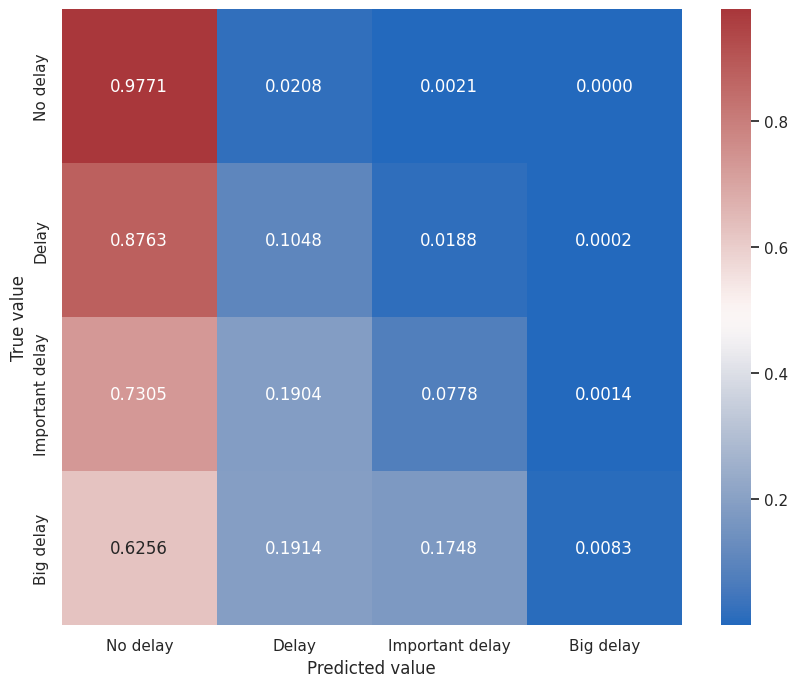

In [ ]:
# Evaluate performance with various metrics
Y_pred = mlp_model(X_test)

print('Accuracy = {:.3f}'.format(multiclass_accuracy(Y_pred, Y_test, average='macro', num_classes=4)))
print('Precision = {:.3f}'.format(multiclass_precision(Y_pred, Y_test, average='macro', num_classes=4)))
print('Recall = {:.3f}'.format(multiclass_recall(Y_pred, Y_test, average='macro', num_classes=4)))
print('F1-score = {:.3f}'.format(multiclass_f1_score(Y_pred, Y_test, average='macro', num_classes=4)))
print('Area under PRC = {:.3f}'.format(multiclass_auprc(Y_pred, Y_test, average='macro', num_classes=4)))

conf_matrix = multiclass_confusion_matrix(Y_pred, Y_test, num_classes=4, normalize='true').cpu().numpy()
conf_matrix = pd.DataFrame(conf_matrix, index=['No delay', 'Delay', 'Important delay', 'Big delay'], columns=['No delay', 'Delay', 'Important delay', 'Big delay'])

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='vlag', fmt='.4f')
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()

## With DEPARTURE_DELAY feature

In [ ]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop(['ARRIVAL_DELAY'], axis=1))
Y = data['ARRIVAL_DELAY']

In [ ]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
print(Counter(Y_train))

# SMOTE over-sampling
#oversample = SMOTE(sampling_strategy={2: 100000, 3:20000})
#X_train, Y_train = oversample.fit_resample(X_train, Y_train)
# random under-sampling
undersample = RandomUnderSampler(sampling_strategy={0: 500000})
X_train, Y_train = undersample.fit_resample(X_train, Y_train)
print('After balancing the classes: ', Counter(Y_train))
# Standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Training data to tensors
X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
Y_train = torch.as_tensor(np.array(Y_train), device=device)
X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.as_tensor(np.array(Y_test), device=device)

Train samples:  976964
Test samples:  418700
Counter({0: 788206, 1: 128950, 2: 50797, 3: 9011})
After balancing the classes:  Counter({0: 500000, 1: 128950, 2: 50797, 3: 9011})


In [ ]:
# Instantiate the model
mlp_model = AttentionMLP(X.shape[1], 100, 100, 100, 50, 4)
# Loss function
loss_criterion = nn.CrossEntropyLoss()
# Adam optimizer
# learning rates tested [1-e3, 1e-4, 1e-5]
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-5)

# Define number of epochs and mini-batch size
num_epochs = 50
# batch sizes tested [500, 1000, 2000]
batch_size = 5000

# DataLoader for creating training and validation batches
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#----------
# Training
#----------

train_loss_array = []
test_loss_array = []

# Epoch loop
for e in range(num_epochs):
  # Training step
  train_loss, train_attention_weights = train_loop(mlp_model, train_loader, optimizer, loss_criterion, train_loss_array)
  # Save epoch loss for plot
  train_loss_array.append(train_loss)
  # Validation step
  test_loss, test_attention_weights = test_loop(mlp_model, test_loader, optimizer, loss_criterion, test_loss_array)
  # Save epoch loss for plot
  test_loss_array.append(test_loss)

  print(f'Epoch [{e+1}/{num_epochs}], Training loss: {train_loss:.4f}, Test loss: {test_loss: 4f}')

Epoch [1/50], Training loss: 1.4482, Test loss:  1.451875
Epoch [2/50], Training loss: 1.4047, Test loss:  1.400153
Epoch [3/50], Training loss: 1.3343, Test loss:  1.315754
Epoch [4/50], Training loss: 1.2203, Test loss:  1.180249
Epoch [5/50], Training loss: 1.0665, Test loss:  0.995050
Epoch [6/50], Training loss: 0.9278, Test loss:  0.821203
Epoch [7/50], Training loss: 0.8537, Test loss:  0.715875
Epoch [8/50], Training loss: 0.8055, Test loss:  0.659470
Epoch [9/50], Training loss: 0.7798, Test loss:  0.639406
Epoch [10/50], Training loss: 0.7479, Test loss:  0.623376
Epoch [11/50], Training loss: 0.7637, Test loss:  0.618434
Epoch [12/50], Training loss: 0.7337, Test loss:  0.597652
Epoch [13/50], Training loss: 0.7158, Test loss:  0.564976
Epoch [14/50], Training loss: 0.6816, Test loss:  0.565041
Epoch [15/50], Training loss: 0.6769, Test loss:  0.557968
Epoch [16/50], Training loss: 0.6914, Test loss:  0.551113
Epoch [17/50], Training loss: 0.6851, Test loss:  0.538240
Epoch 

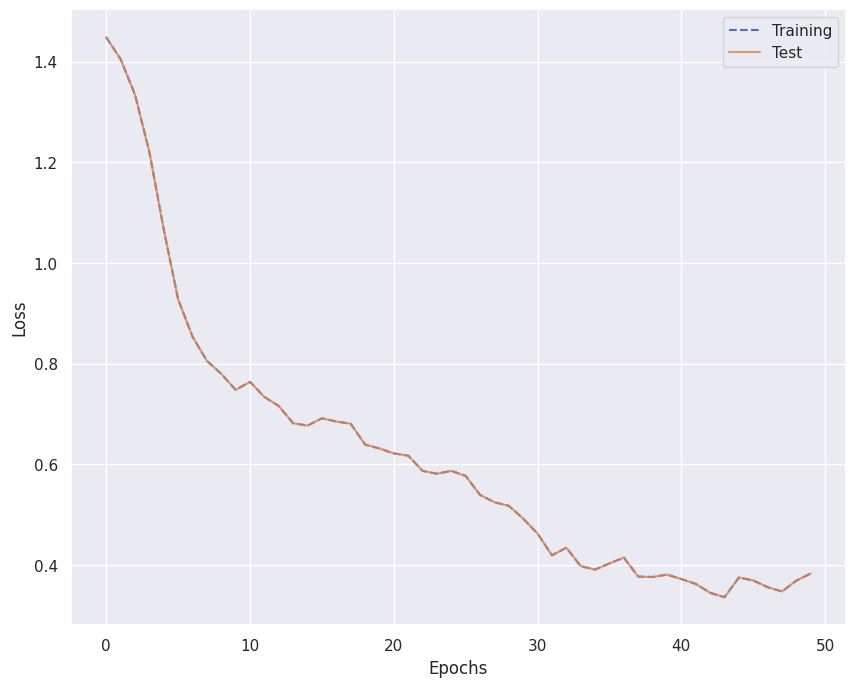

In [ ]:
plt.figure()
plt.plot(range(num_epochs), train_loss_array, label='Training', linestyle='dashed')
plt.plot(range(num_epochs), train_loss_array, label='Test', alpha=0.8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Test the model

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    total_loss_test = 0.0
    correct_predictions_test = 0
    total_samples_test = 0

    for inputs_test, labels_test in test_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

        outputs_test = mlp_model(inputs_test)
        loss_test = loss_criterion(outputs_test, labels_test)
        total_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test, 1)
        correct_predictions_test += (predicted_test == labels_test).sum().item()
        total_samples_test += labels_test.size(0)

    average_loss_test = total_loss_test / len(test_loader)
    accuracy_test = correct_predictions_test / total_samples_test

    print(f'Average test loss: {average_loss_test:.4f}, Accuracy: {accuracy_test * 100:.2f}%')

Average test loss: 0.3253, Accuracy: 88.91%


Accuracy = 0.799
Precision = 0.762
Recall = 0.799
F1-score = 0.777
Area under PRC = 0.653


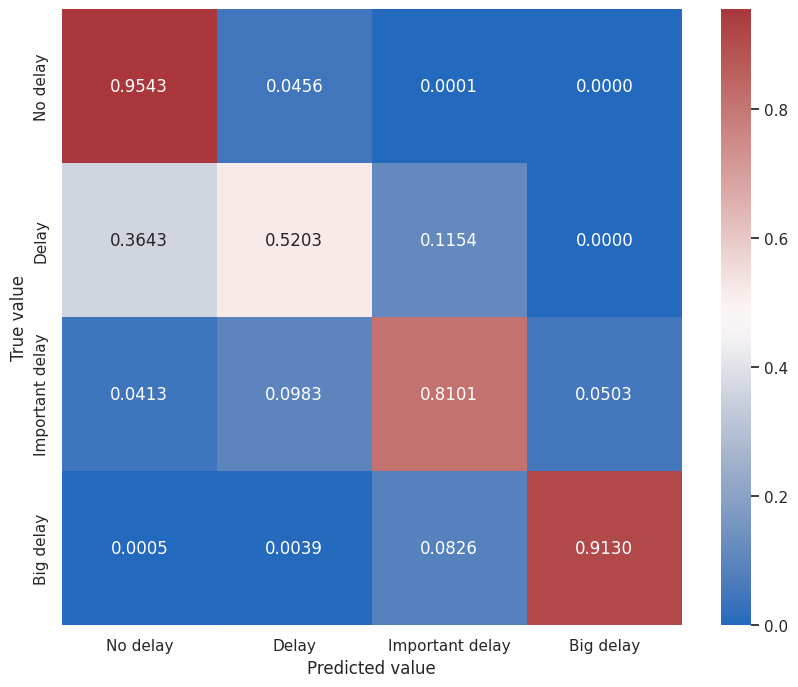

In [ ]:
# Evaluate performance with various metrics
Y_pred, attention_weights = mlp_model(X_test)

print('Accuracy = {:.3f}'.format(multiclass_accuracy(Y_pred, Y_test, average='macro', num_classes=4)))
print('Precision = {:.3f}'.format(multiclass_precision(Y_pred, Y_test, average='macro', num_classes=4)))
print('Recall = {:.3f}'.format(multiclass_recall(Y_pred, Y_test, average='macro', num_classes=4)))
print('F1-score = {:.3f}'.format(multiclass_f1_score(Y_pred, Y_test, average='macro', num_classes=4)))
print('Area under PRC = {:.3f}'.format(multiclass_auprc(Y_pred, Y_test, average='macro', num_classes=4)))

conf_matrix = multiclass_confusion_matrix(Y_pred, Y_test, num_classes=4, normalize='true').cpu().numpy()
conf_matrix = pd.DataFrame(conf_matrix, index=['No delay', 'Delay', 'Important delay', 'Big delay'], columns=['No delay', 'Delay', 'Important delay', 'Big delay'])

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='vlag', fmt='.4f')
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()